## Install Required Packages

In [1]:
!pip install statsmodels

In [2]:
!pip install prophet

## Import Libraries

In [3]:
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

## Load Price Data

In [4]:
# Load price data
df_price = pd.read_csv('data/combined_crypto_data.csv')
df_price = df_price[['Date', 'crypto_code', 'Adj Close']]
df_price = df_price.rename(columns= {'Date': 'date'})
df_price

,date,crypto_code,Adj Close
0,2023-05-30,BTC-USD,27702.349609
1,2023-05-31,BTC-USD,27219.658203
2,2023-06-01,BTC-USD,26819.972656
3,2023-06-02,BTC-USD,27249.589844
4,2023-06-03,BTC-USD,27075.128906
...,...,...,...
1093,2024-05-25,ADA-USD,0.462072
1094,2024-05-26,ADA-USD,0.458375
1095,2024-05-27,ADA-USD,0.467963
1096,2024-05-28,ADA-USD,0.456990


## Load Sentiment Data

In [5]:
# Load sentiment data
df_sentiment = pd.read_csv('data/combined_crypto_news_with_sentiment.csv', sep=';')
df_sentiment = df_sentiment[['date', 'crypto_code', 'title', 'sentiment_SIA']]
df_sentiment = df_sentiment.groupby(by=['date', 'crypto_code'], as_index=False).mean()
df_sentiment

C:\Users\windows\AppData\Local\Temp\ipykernel_7520\762760937.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sentiment = df_sentiment.groupby(by=['date', 'crypto_code'], as_index=False).mean()


,date,crypto_code,sentiment_SIA
0,2024-05-05,ADA-USD,0.000000
1,2024-05-06,ADA-USD,0.000000
2,2024-05-08,ADA-USD,0.000000
3,2024-05-10,ADA-USD,-0.363450
4,2024-05-13,ADA-USD,0.000000
5,2024-05-15,ADA-USD,0.000000
6,2024-05-17,ADA-USD,0.000000
7,2024-05-20,ADA-USD,0.000000
8,2024-05-22,ADA-USD,0.000000
9,2024-05-24,ADA-USD,0.000000


## Merge Price and Sentiment Data

In [6]:
# Merge price and sentiment data
df = df_price.merge(df_sentiment, on=['date', 'crypto_code'], how='left')
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['Adj Close'])
df

,date,crypto_code,Adj Close,sentiment_SIA
0,2023-05-30,BTC-USD,27702.349609,NaN
1,2023-05-31,BTC-USD,27219.658203,NaN
2,2023-06-01,BTC-USD,26819.972656,NaN
3,2023-06-02,BTC-USD,27249.589844,NaN
4,2023-06-03,BTC-USD,27075.128906,NaN
...,...,...,...,...
1093,2024-05-25,ADA-USD,0.462072,NaN
1094,2024-05-26,ADA-USD,0.458375,NaN
1095,2024-05-27,ADA-USD,0.467963,0.0
1096,2024-05-28,ADA-USD,0.456990,NaN


## Forecast using Prophet with Sentiment

21:12:14 - cmdstanpy - INFO - Chain [1] start processing
21:12:14 - cmdstanpy - INFO - Chain [1] done processing


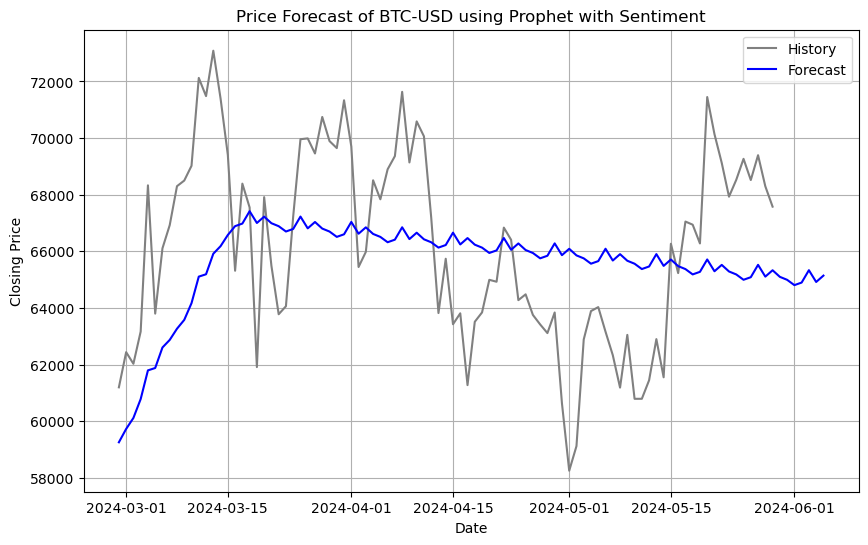

21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing


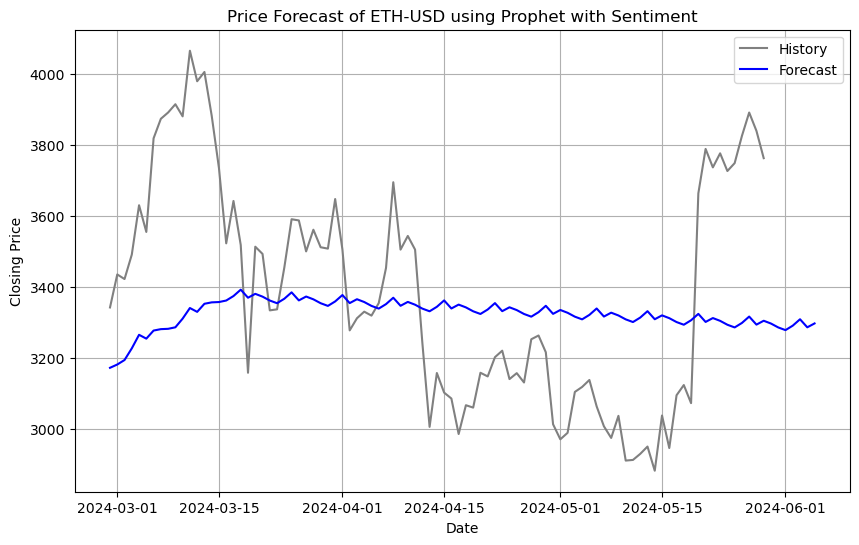

21:12:17 - cmdstanpy - INFO - Chain [1] start processing
21:12:18 - cmdstanpy - INFO - Chain [1] done processing


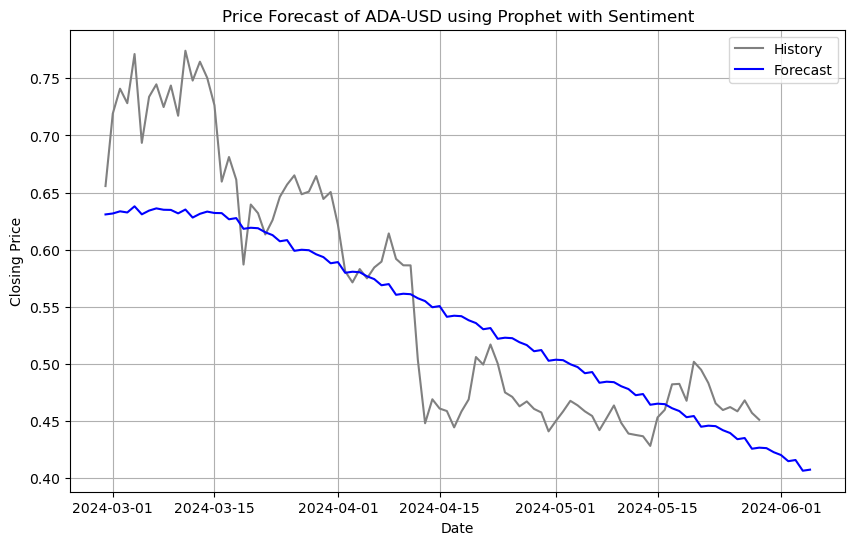

In [7]:
# Forecast using Prophet with Sentiment
for crypto_code in df['crypto_code'].unique():
    crypto_data = df[df['crypto_code'] == crypto_code]

    # Sort by date
    crypto_data = crypto_data.sort_values(by='date')

    # Ensure 'sentiment_SIA' column exists
    if 'sentiment_SIA' not in crypto_data.columns:
        raise ValueError(f"'sentiment_SIA' column does not exist in the data for {crypto_code}")

    # Create DataFrame for Prophet
    prophet_data = crypto_data.rename(columns={'date': 'ds', 'Adj Close': 'y', 'sentiment_SIA': 'sentiment'})

    # Handle missing values in 'sentiment' column
    prophet_data['sentiment'] = prophet_data['sentiment'].fillna(method='ffill').fillna(method='bfill')

    # Fill with a constant value if there are still missing values
    if prophet_data['sentiment'].isnull().any():
        print(f"{crypto_code}: Still have missing values after ffill and bfill.")
        prophet_data['sentiment'] = prophet_data['sentiment'].fillna(0)

    # Ensure 'y' column has no missing values and drop rows with null 'y'
    prophet_data = prophet_data.dropna(subset=['y'])

    # Check if there are enough data points to train the model
    if prophet_data.shape[0] < 2:
        print(f"Insufficient data to train Prophet model for {crypto_code}.")
        continue

    # Configure Prophet model
    model_prophet = Prophet()
    model_prophet.add_regressor('sentiment')  # Add sentiment as regressor

    # Fit Prophet model
    model_prophet.fit(prophet_data)

    # Forecast next 7 days
    future = model_prophet.make_future_dataframe(periods=7)

    # Fill 'sentiment' column in 'future' DataFrame with a constant value
    future['sentiment'] = 0

    forecast_prophet = model_prophet.predict(future)

    # Get date one month ago from the last date of historical data
    last_date = prophet_data['ds'].max()
    one_month_ago = last_date - pd.DateOffset(months=3)

    # Filter data to get only the last month
    prophet_data_last_month = prophet_data[prophet_data['ds'] >= one_month_ago]
    forecast_prophet_last_month = forecast_prophet[forecast_prophet['ds'] >= one_month_ago]

    # Visualize results
    plt.figure(figsize=(10, 6))

    # Plot history of the last month
    plt.plot(prophet_data_last_month['ds'], prophet_data_last_month['y'], color='gray', label='History')

    # Plot forecast of the last month
    plt.plot(forecast_prophet_last_month['ds'], forecast_prophet_last_month['yhat'], color='blue', label='Forecast')

    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Price Forecast of {crypto_code} using Prophet with Sentiment')
    plt.legend()
    plt.grid(True)
    plt.show()

## Forecast using Prophet with Sentiment

21:12:18 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing


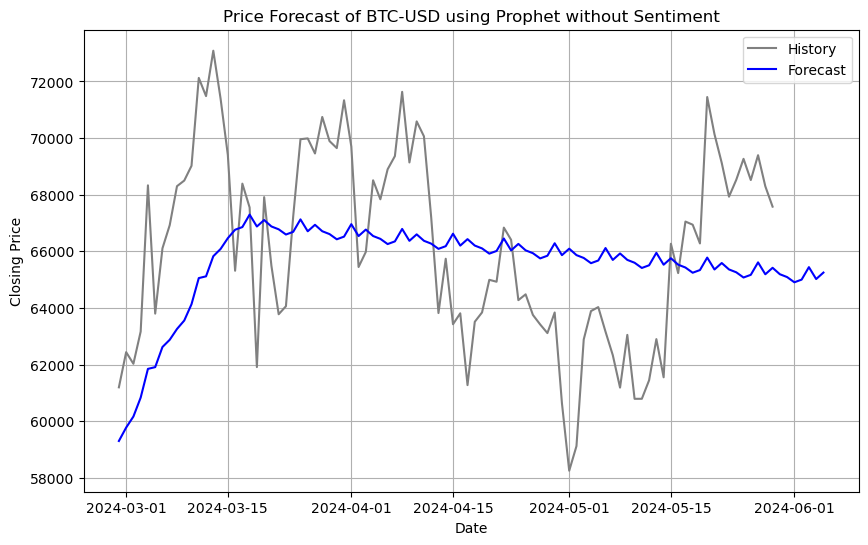

21:12:19 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing


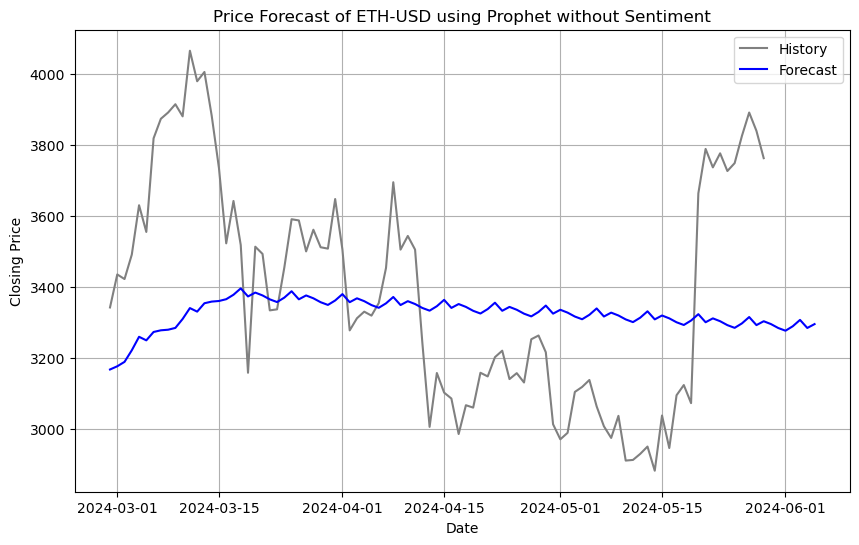

21:12:20 - cmdstanpy - INFO - Chain [1] start processing
21:12:21 - cmdstanpy - INFO - Chain [1] done processing


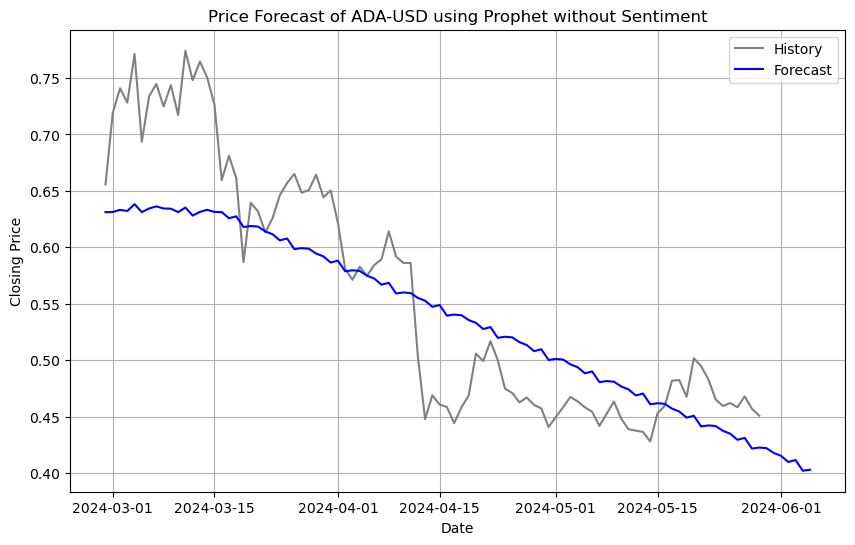

In [10]:
# Forecast using Prophet without Sentiment
for crypto_code in df['crypto_code'].unique():
    crypto_data_no_sentiment = df[df['crypto_code'] == crypto_code]
    
    # Renombrar columnas del DataFrame
    crypto_data_no_sentiment = crypto_data_no_sentiment.rename(columns={'date': 'ds', 'Adj Close': 'y'})

    # Sort by date
    crypto_data_no_sentiment = crypto_data_no_sentiment.sort_values(by='ds')

    # Ensure 'y' column has no missing values and drop rows with null 'y'
    crypto_data_no_sentiment = crypto_data_no_sentiment.dropna(subset=['y'])
    
    # Check if there are enough data points to train the model
    if crypto_data_no_sentiment.shape[0] < 2:
        print(f"Insufficient data to train Prophet model for {crypto_code}.")
        continue

    # Configure Prophet model without sentiment
    model_prophet_no_sentiment = Prophet()

    # Fit Prophet model
    model_prophet_no_sentiment.fit(crypto_data_no_sentiment)

    # Forecast next 7 days without sentiment
    future_no_sentiment = model_prophet_no_sentiment.make_future_dataframe(periods=7)

    forecast_prophet_no_sentiment = model_prophet_no_sentiment.predict(future_no_sentiment)

    # Get date one month ago from the last date of historical data
    last_date_no_sentiment = crypto_data_no_sentiment['ds'].max()
    one_month_ago_no_sentiment = last_date_no_sentiment - pd.DateOffset(months=3)

    # Filter data to get only the last month without sentiment
    one_month_ago_no_sentiment = pd.Timestamp(one_month_ago_no_sentiment)
    crypto_data_last_month_no_sentiment = crypto_data_no_sentiment[crypto_data_no_sentiment['ds'] >= one_month_ago_no_sentiment]
    forecast_prophet_last_month_no_sentiment = forecast_prophet_no_sentiment[forecast_prophet_no_sentiment['ds'] >= one_month_ago_no_sentiment]

    # Visualize results without sentiment
    plt.figure(figsize=(10, 6))
    plt.plot(crypto_data_last_month_no_sentiment['ds'], crypto_data_last_month_no_sentiment['y'], color='gray', label='History')
    plt.plot(forecast_prophet_last_month_no_sentiment['ds'], forecast_prophet_last_month_no_sentiment['yhat'], color='blue', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Price Forecast of {crypto_code} using Prophet without Sentiment')
    plt.legend()
    plt.grid(True)
    plt.show()